In [1]:
%reload_ext autoreload
%autoreload 2

In [10]:
!pip install openpyxl tenacity loguru  python-dotenv rake-nltk seaborn -qq
!pip install git+https://git@github.com/NASA-IMPACT/evalem.git@develop -qq

In [2]:
import ast
import glob
import json
import os
import random
import re
from typing import List

In [3]:
from pprint import pprint
from IPython.display import display, HTML

In [4]:
from loguru import logger

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
from dotenv import load_dotenv

In [7]:
load_dotenv()

True

In [72]:
!unzip ../data/osdr-eval.zip -d ../data

Archive:  ../data/osdr-eval.zip
   creating: ../data/osdr-eval/
  inflating: ../data/osdr-eval/responses-gpt-3.5-turbo.csv  
  inflating: ../data/osdr-eval/osdr-eval-retrieval-kws.csv  
  inflating: ../data/osdr-eval/OSDR_LLM_QA_correctFormat.xlsx  
  inflating: ../data/osdr-eval/responses-simplified-gpt-3.5-turbo-rephrased.csv  
  inflating: ../data/osdr-eval/osdr-eval-retrieval-semantic.csv  


# Load Validation Data

In [73]:
FILE_PATH = "../data/osdr-eval/OSDR_LLM_QA_correctFormat.xlsx"

In [74]:
def load_data(path) -> pd.DataFrame:
    data = pd.read_excel(path)
    data = data.rename(columns={data.columns[0]: 'context'})
    return data

In [75]:
def simplify_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    transformed_data = []
    for index, row in df.iterrows():
        context = row['context']
        url = row['URL']
        for i in range(1, 6): # Assuming there are 5 question-answer pairs
            question = row[f'Question {i}']
            answer = row[f'Question {i} Answer']
            if question and answer:
                transformed_data.append(dict(
                    context=context,
                    context_hash=abs(hash(context)) % (10 ** 8),
                    url=url,
                    question=question,
                    answer=answer,
                ))
    df =  pd.DataFrame(transformed_data)
    return df.dropna(subset=['question', 'answer'], how='all')

In [76]:
data = load_data(FILE_PATH)
data.head()

,context,URL,Question 1,Question 1 Answer,Question 2,Question 2 Answer,Question 3,Question 3 Answer,Question 4,Question 4 Answer,Question 5,Question 5 Answer
0,Genome-wide transcriptional profiling showed t...,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
1,The objective of the Rodent Research-5 (RR-5) ...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...,How many days after launch were the mice treat...,Six days after launch,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen...",What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...
2,The radiation bystander response is an importa...,https://sciencediscoveryengine.nasa.gov#/previ...,What is a key component of the overall respons...,The radiation bystander response,Which methods were used to measure the bystand...,using chromosomal aberration and micronucleus ...,What was shown to increase chromosomal structu...,depletion or mutation of RAD9,what cellular pathways were altered as a resul...,The depletion of RAD9 caused changes in numero...,How were differences in the activation of tran...,The use of network analysis allowed the discov...
3,Martian regolith (unconsolidated surface mater...,https://sciencediscoveryengine.nasa.gov#/previ...,What is considered a potential medium for plan...,Martian regolith (unconsolidated surface mater...,What is the level of hydrated magnesium sulfat...,hydrated magnesium sulfate mineral levels in t...,What was characterized in the study to identif...,The early Arabidopsis root transcriptome respo...,how was the genetic comparison approached to d...,A comparative analysis was conducted between t...,What distinctive characteristic does the cax1-...,The cax1-1 mutant line demonstrated relative t...
4,The objective of the Rodent Research-23 missio...,https://sciencediscoveryengine.nasa.gov#/previ...,What was the objective of the Rodent Research-...,to better understand the effects of spacefligh...,How many mice and of what type were involved i...,"twenty male, C57BL/6J, 16-17 weeks-old mice",How long were the mice in the RR-23 study main...,maintained in microgravity for 38 days,What was the procedure followed for the mice f...,"The mice, after landing in the Atlantic, were ...",How was RNA extraction and analysis managed fo...,Adrenal glands of the mice were preserved by i...


## Data Peek

Here we pick a sample row to inspect the nature of data.
- What each column looks like

In [77]:
def peek_data(data: pd.DataFrame, row_index: int = 0):
    print(f"Row = {row_index}")
    row = data.iloc[row_index]
    for col, value in zip(data.columns, row):
        display(HTML(f"<h4>{col}</h4>"))
        print(value)
        display(HTML("<hr/>"))

In [78]:
data.shape

(60, 12)

In [79]:
# index = random.randint(0, len(data))
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


What is overrepresented in the different experiments despite particular genes not being common?


the same GO groups including a large multigene family related with behavior, stress response and organogenesis


what analytical methodology provided integrative insights on transcriptome variations?


Self-organizing maps of the Gene Expression Dynamics Inspector (GEDI) were utilized to reveal transcriptome variations under various environmental conditions or microgravity/hypergravity simulation devices.


What are the implications of the findings in terms of the tuning of the transcriptome to Earth's gravity and its variations in extreme environmental conditions?


The findings indicate that the finely adjusted transcriptome is tuned to normal Earth gravity, showing a more marked and coherent genetic response when environmental conditions significantly deviate from optimal.


## Simplify Data

Here we separate out individual question/answer pair into separate row for each context.


This is used for simplifying the validation process so that each row would have consistent view of data.

In [80]:
data = simplify_columns(data)
data.head(10)

,context,context_hash,url,question,answer
0,Genome-wide transcriptional profiling showed t...,88473883,https://sciencediscoveryengine.nasa.gov#/previ...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...
1,Genome-wide transcriptional profiling showed t...,88473883,https://sciencediscoveryengine.nasa.gov#/previ...,What kind of experiments showed differential r...,simulation experiments on ground testing space...
2,Genome-wide transcriptional profiling showed t...,88473883,https://sciencediscoveryengine.nasa.gov#/previ...,What is overrepresented in the different exper...,the same GO groups including a large multigene...
3,Genome-wide transcriptional profiling showed t...,88473883,https://sciencediscoveryengine.nasa.gov#/previ...,what analytical methodology provided integrati...,Self-organizing maps of the Gene Expression Dy...
4,Genome-wide transcriptional profiling showed t...,88473883,https://sciencediscoveryengine.nasa.gov#/previ...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...
5,The objective of the Rodent Research-5 (RR-5) ...,43632810,https://sciencediscoveryengine.nasa.gov#/previ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...
6,The objective of the Rodent Research-5 (RR-5) ...,43632810,https://sciencediscoveryengine.nasa.gov#/previ...,What type of mice and how old were they when f...,a cohort of forty 30-weeks-old female BALB/cAn...
7,The objective of the Rodent Research-5 (RR-5) ...,43632810,https://sciencediscoveryengine.nasa.gov#/previ...,How many days after launch were the mice treat...,Six days after launch
8,The objective of the Rodent Research-5 (RR-5) ...,43632810,https://sciencediscoveryengine.nasa.gov#/previ...,How was the Earth recovery period for the subj...,"Following their return to Earth, the experimen..."
9,The objective of the Rodent Research-5 (RR-5) ...,43632810,https://sciencediscoveryengine.nasa.gov#/previ...,What specific type of samples and from which c...,GeneLab received RNA later preserved dorsal sk...


In [81]:
data.shape

(295, 5)

In [82]:
peek_data(data, row_index=0)

Row = 0


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

88473883


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


Where were the gene expression alterations in Drosophila observed during their metamorphosis?


reducing gravity levels in the International Space Station (ISS)


In [83]:
peek_data(data, row_index=1)

Row = 1


Genome-wide transcriptional profiling showed that reducing gravity levels in the International Space Station (ISS) causes important alterations in Drosophila gene expression intimately linked to imposed spaceflight-related environmental constrains during Drosophila metamorphosis. However, simulation experiments on ground testing space-related environmental constraints, show differential responses. Curiously, although particular genes are not common in the different experiments, the same GO groups including a large multigene family related with behavior, stress response and organogenesis are over represented in them. A global and integrative analysis using the gene expression dynamics inspector (GEDI) self-organizing maps, reveals different degrees in the responses of the transcriptome when using different environmental conditions or microgravity/hypergravity simulation devices. These results suggest that the transcriptome is finely tuned to normal gravity. In regular environmental cond

88473883


https://sciencediscoveryengine.nasa.gov#/preview?id=%2FSDE%2Fgenelab_lsda%2F%7Chttps:%2F%2Fosdr.nasa.gov%2Fbio%2Frepo%2Fdata%2Fstudies%2FOSD-70%2F&query=%7B%22name%22:%22query-smd-primary%22,%22scope%22:%22All%22,%22text%22:%22osd-70%22%7D


What kind of experiments showed differential responses in gene expression?


simulation experiments on ground testing space-related environmental constraints


# promptlab 


**promptlab** provides a programmatic approach to interact with the bot via its REST API.
Specificially, the `/process/` endpoint can process any query and generate the respond accordingly.
https://api.promptlab.nasa-impact.net/api/v1/process/

We can send a request to the API with the query/question and get the response.

Here, the `FlowRunner` class abstracts everything. Its `.run(...)` method processes the query which:
- Takes in a query string
- Returns a result json/dictionary

The result from the API tentatively gives us following information:

- *question* : input question fed into the bot
- *answer* : generated answer based on retrieved contexts
- *retrieved contexts* : List of **top-k** contexts retrieved by the RAG system

## setup flow processors

In [84]:
import requests
from typing import Optional, Union
import urllib.parse

In [85]:
from loguru import logger

In [86]:
from tenacity import retry, retry_if_result, stop_after_attempt, wait_fixed, retry_if_exception, retry_if_exception_type

In [87]:
# Setup the base URL to point to the production
BASE_API_URL = "https://api.promptlab.nasa-impact.net/api/v1/process/"

# Setup api key to authenticate

PROMPTLAB_API_KEY = os.environ["PROMPTLAB_API_KEY"]
assert PROMPTLAB_API_KEY

In [29]:
# tweaks for the OSDR bot flow
TWEAKS = {
  "ConversationalRetrievalChain-83vns": {},
  "ChatOpenAI-gsfUD": {"model": "gpt-3.5-turbo"},
  "ConversationBufferMemory-z2ZqE": {},
  "Sinequa-Z8S73": {}
}

# flow id of the OSDR bot in promptlab that is used for QA programmatically
FLOW_ID = "1edbe0f9-d7ff-4c2a-a371-5f6312964f05"

In [88]:
class FlowRunner:
    def __init__(self, base_url: str, api_key: str, debug:bool = False) -> None:
        self.base_url = base_url
        self.api_key = api_key
        self.debug=bool(debug)

    def run_flow(
        self,
        inputs: dict,
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        """
        Run a flow with a given message and optional tweaks.
    
        :param message: The message to send to the flow
        :param flow_id: The ID of the flow to run
        :param tweaks: Optional tweaks to customize the flow
        :return: The JSON response from the flow
        """
        api_url = urllib.parse.urljoin(self.base_url, flow_id)
        if self.debug:
            logger.debug(f"URL = {api_url}")

        api_key = self.api_key
        payload = {"inputs": inputs}
        headers = None
        if tweaks:
            payload["tweaks"] = tweaks
        if api_key:
            headers = {"x-api-key": api_key}
        response = requests.post(api_url, json=payload, headers=headers)
        if self.debug:
            logger.debug(f"response = {response}")
            logger.debug(f"status code = {response.status_code}")
        if response.status_code != 200:
            raise requests.exceptions.HTTPError(f"Error: {response.status_code}")
        return response.json()

    @staticmethod
    def if_not_valid_result(result: dict) -> bool:
        return not (isinstance(result, dict) and "result" in result and "answer" in result.get("result", {}))
    
    @retry(
        retry=(retry_if_exception_type(requests.exceptions.RequestException) | retry_if_result(if_not_valid_result)),
        stop=stop_after_attempt(3),
        wait=wait_fixed(2)
    )
    def run(
        self,
        input: Union[dict, str],
        flow_id: str,
        tweaks: Optional[dict] = None,
    ) -> dict:
        if isinstance(input, str):
            input = dict(question=input)
        result = self.run_flow(
            inputs=input,
            flow_id=flow_id,
            tweaks=tweaks,
        )
        result["question"] = input["question"] if isinstance(input, dict) else input

        if "result" in result:
            source_documents = result.get("result", {}).get("source_documents", "[]")
            if isinstance(source_documents, str):
                result["result"]["source_documents"] = json.loads(source_documents)
        return result

    @staticmethod
    def display_result(result: dict, question: Optional[str]=None, reference_answer=None):
        header_tag = "h4"
        question = result.get("question", question)
        if question:
            display(HTML(f"<{header_tag}>Question</{header_tag}>"))
            print(question)
            display(HTML("<hr/>"))

        if "result" in result:
            result = result["result"]
        display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
        print(result["answer"])
        display(HTML("<hr/>"))

        if reference_answer:
            display(HTML(f"<{header_tag}>Exepcted Answer (Reference/Ground Truth)</{header_tag}>"))
            print(reference_answer)
            display(HTML("<hr/>"))
        
        # display(HTML(f"<{header_tag}>Retrieved Contexts</{header_tag}>"))
        for idx, doc in enumerate(result["source_documents"], start=1):
            display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
            print(doc["page_content"])
            print(doc["metadata"]["source"])
            display(HTML("<hr/>"))

## Test Run

Now, let's check what a sample test run looks like when we call the API for QA.

In [89]:
flow_runner = FlowRunner(
    base_url=BASE_API_URL,
    api_key=PROMPTLAB_API_KEY
)

In [32]:
query = "What parasites were sent to ISS to study host immunity?"

In [33]:
result = flow_runner.run(
    input=query,
    flow_id=FLOW_ID,
    tweaks=TWEAKS,
)

In [34]:
result["question"]

'What parasites were sent to ISS to study host immunity?'

In [35]:
flow_runner.display_result(result)

What parasites were sent to ISS to study host immunity?


In the study mentioned, fruit flies and their parasitic wasps were sent to the ISS to examine changes in host immunity and parasite virulence. The specific parasites mentioned in the study are Leptopilina boulardi 17 and Leptopilina heterotoma 14.


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Drosophila melanogaster data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina boulardi 17 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence. Key findings from this work are as follows: (a) Spaceflight spiked the expression of inflammation genes in fruit flies; (b) Spaceflight enhanced tumor growth in flies already suffering from chronic inflammation; (c) Spaceflight did not significantly affect parasitic wasp development, emergence, or the expression of virulence genes; (d) <b>Parasite</b> mutants with visible wing color and shape alterations were obtained. This <b>study</b> contains Leptopilina heterotoma14 data.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  1.26 TB  OSD-588 Version 1  Drosophila parasitoids go to space: Unexpected effects of spaceflight on <b>hosts</b> and their parasitoids - Drosophila data <b>Study</b>  Submitted Date: 02-Feb-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-583 DOI : 10.26030/v9rh-5a70  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-588/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  148.92 GB  OSD-610 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina boulardi 17 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-587 DOI : 10.26030/9ee4-6s36  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-610/


About  Charter  How to Join  Current AWG Members  Citizen Science  SOLSTICE  SOLSTICE Members  FAQ  Terms & Conditions  Genelab Tutorials  Contact Us  account_circle expand_more  176.26 GB  OSD-609 Version 1  Drosophila parasitoids go to space: Unexpected and differential effects of spaceflight on <b>hosts</b> and their parasitoids - Wasp Leptopilina heterotoma 14 data <b>Study</b>  Submitted Date: 28-Apr-2023  Initial Release Date: 02-Jan-2024  notifications share  GeneLab ID : GLDS-586 DOI : 10.26030/5rjq-a347  Cite this <b>Study</b>  info Description  Description  In this <b>study</b>, fruit flies and their parasitic wasps were <b>sent</b> to the <b>ISS</b> to examine changes in <b>host</b> <b>immunity</b> and <b>parasite</b> virulence.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-609/


The biology chosen for this experiment was Arabidopsis thaliana, ecotype Col-0, because of the plant's history of spaceflight experimentation within KFTs and wealth of comparative data from orbital experiments. KFTs were deployed as a wearable device, a leg pouch attached to the astronaut, which proved to be operationally effective during the course of the flight. Data from the inflight samples indicated that the microgravity period of the flight elicited the strongest transcriptomic responses as measured by the number of genes showing differential expression.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-624/


Fungal Pathogenesis , Tumorigenesis , and Effects of <b>Host</b> <b>Immunity</b> in Space  Project Type  Spaceflight <b>Study</b>  Flight Program  Space Transportation System (STS)  Experiment Platform  Shuttle Life Sciences Research (Middeck)  Sponsoring Agency  NASA  NASA Center  Ames Research Center (ARC)  Funding Source  This <b>study</b> work was supported by a NASA grant to SB for Fungal Pathogenesis, Tumorigenesis, and Effects of <b>Host</b> <b>Immunity</b> in the Space Environment (FSB-FIT-2005). The funder had a role in <b>study</b> design and in supporting data collection.  Acknowledgments  We thank David Schneider for helping us with the design of this experiment.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-3/


Spaceflight uniquely alters the physiology of both human cells and microbial pathogens, stimulating cellular and molecular changes directly relevant to infectious disease. However, the influence of this environment on host-pathogen interactions remains poorly understood. Here we report our results from the STL-IMMUNE study flown aboard Space Shuttle mission STS-131, which investigated multi-omic responses (transcriptomic, proteomic) of human intestinal epithelial cells to infection with Salmonella Typhimurium when both host and pathogen were simultaneously exposed to spaceflight. To our knowledge, this was the first in-flight infection and dual RNA-seq analysis using human cells.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-323/


Immune dysregulation is among the main adverse outcomes of spaceflight. Despite its crucial role in host protection, effects on the human antibody repertoire are unknown. Consequently, we examined the IgM repertoire of five cosmonauts 25 days before launch, after 64 and 129 days spent on the International Space Station (ISS), and after 1, 7 and 30 days of Earth reambulation using high-throughput sequencing. This is the first study of this kind.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-316/


# Run OSDR Validation set

Instead of manually running each question through the bot to generate the answer, we run all the questions from the validation data in bulk.

We have some functions for housekeeping and the details for them are hidden away for brevity.

> Note: Since it takes some time to run through all the questions, we'll pre-load the responses from a csv.

In [90]:
from tqdm import tqdm
from joblib import Parallel, delayed
import ast

In [91]:
def process_row(row, flow_runner, flow_id, tweaks):
    try:
        result = flow_runner.run(input=row.question, flow_id=flow_id, tweaks=tweaks)
    except:
        logger.error(f"Error for question={row.question}. Skipping")
        result = {}
    print(result.keys())
    result["reference_context"] = row.context
    result["reference_answer"] = row.answer
    result["context_hash"] = row.context_hash
    return result

In [92]:
def get_osdr_responses(
    data: pd.DataFrame,
    flow_runner: FlowRunner,
    flow_id,
    tweaks
) -> pd.DataFrame:
    results = []
    for row in tqdm(data.itertuples()):
        result = process_row(row, flow_runner, flow_id, tweaks)
        results.append(result)
    return pd.DataFrame(results)

def get_osdr_responses_parallel(
    data: pd.DataFrame,
    flow_runner,
    flow_id, 
    tweaks
) -> pd.DataFrame:
    results = Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)\
        (row, flow_runner, flow_id, tweaks) for row in tqdm(data.itertuples(index=False))
    )
    results_df = pd.DataFrame(results)
    return results_df

In [93]:
def load_responses(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["result"] = df["result"].apply(ast.literal_eval)
    return df

In [94]:
# # get all the responses
# responses = get_osdr_responses_parallel(
#     data=simplify_columns(load_data(FILE_PATH)).iloc[:],
#     flow_runner=flow_runner,
#     flow_id=FLOW_ID,
#     tweaks=TWEAKS
# )

In [95]:
# load already dumped responses
responses = load_responses("../data/osdr-eval/responses-gpt-3.5-turbo.csv")

In [96]:
responses.head(3)

,result,status,task,session_id,backend,question,reference_context,reference_answer,context_hash
0,{'answer': 'The gene expression alterations in...,NaN,"{'id': '139756224681744', 'href': 'api/v1/task...",RG8XKS:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,Where were the gene expression alterations in ...,Genome-wide transcriptional profiling showed t...,reducing gravity levels in the International S...,30225908
1,{'answer': 'Experiments involving reducing gra...,NaN,"{'id': '139756227007232', 'href': 'api/v1/task...",JHTOXO:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What kind of experiments showed differential r...,Genome-wide transcriptional profiling showed t...,simulation experiments on ground testing space...,30225908
2,"{'answer': 'The same GO groups, including a la...",NaN,"{'id': '139756223614704', 'href': 'api/v1/task...",VWW7ZL:6b5b553ba5e766ccbc1429e4540911c1e7ac597...,anyio,What is overrepresented in the different exper...,Genome-wide transcriptional profiling showed t...,the same GO groups including a large multigene...,30225908


In [97]:
# responses.to_csv("data/responses-gpt-3.5-turbo.csv", index=False)

In [58]:
sample_row = responses.sample(1)
FlowRunner.display_result(
    sample_row.result.iloc[0],
    sample_row.question.iloc[0],
    reference_answer=sample_row.reference_answer.iloc[0]
)

When was gait analysis performed in this study?


The gait analysis was performed both pre-flight and post-flight on the mice in this study.


Gait analysis was performed pre-flight and post-flight.


Thus, the purpose of this <b>study</b> was to evaluate <b>gait</b> changes in response to spaceflight. A prospective collection of <b>gait</b> data was collected on 3 groups of mice: those who spent~35 days in orbit (FLIGHT) aboard the International Space Station (ISS); a ground-based control with the same habitat conditions as ISS (Ground Control;
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


The long-term adaptations to microgravity and other spaceflight challenges within the confines of a spacecraft, and readaptations to weight-bearing upon reaching a destination, are unclear. While post-flight <b>gait</b> change in astronauts have been well documented and reflect multi-system deficits, no data from rodents have been collected. Thus, the purpose of this <b>study</b> was to evaluate <b>gait</b> changes in response to spaceflight. A prospective collection of <b>gait</b> data was collected on 3 groups of mice:
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


those who spent~35 days in orbit (FLIGHT) aboard the International Space Station (ISS); a ground-based control with the same habitat conditions as ISS (Ground Control; GC); and a vivarium control with typical rodent housing conditions (VIV). Pre-flight and post-flight <b>gait</b> measurements were conducted utilizing an optimized and portable <b>gait</b> <b>analysis</b> system (DigiGait, Mouse Specifics, Inc). The total data acquisition time for <b>gait</b> patterns of FLIGHT and control mice was 1.5-5 min/mouse, allowing all 20 mice per group to be assessed in less than an hour.
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


The total data acquisition time for <b>gait</b> patterns of FLIGHT and control mice was 1.5-5 min/mouse, allowing all 20 mice per group to be assessed in less than an hour. Patterns of longitudinal <b>gait</b> changes were observed in the hind limbs and the forelimbs of the FLIGHT mice after ~35 days in orbit; few differences were observed in <b>gait</b> characteristics within the GC and VIV controls from the initial to the final <b>gait</b> assessment, and between groups. For FLIGHT mice, 12 out of 18 of the evaluated <b>gait</b> characteristics in the hind limbs were significantly changed, including:
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  Gait  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F1_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  <b>Gait</b>  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F16_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F10_LH_Post  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  <b>Gait</b>  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F11_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  <b>Gait</b>  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F15_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F3_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  Gait  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F3_LH_Post  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No  DigiGait <b>Analysis</b> v.14 software and SigmaPlot v.14  <b>Gait</b>  Not Available  LSDS-34_<b>Gait_Left_Hind_GOOD_RAW_with_RFIDs.xlsx</b>  ALSDA Processed Data  LSDS-34_<b>Gait_willeyTRANSFORMED.csv</b>  F8_LH_Pre  Assay Arrangement  DigiGait System (Mouse Specifics) and DigiGait <b>Analysis</b> v.14  L-8 days (45 total days)  Yes  Treadmill And Chamber  DigiGait manufacturer system  <b>Gait</b> Assay Characteristics  None  1.5-5 minute  17 centimeters per second  4 second  6-8 consecutive strides per animal  Left Only  No
https://osdr.nasa.gov/bio/repo/data/studies/OSD-478/


# Evaluation

Here, we evaluate the generated responses. We primarily follow two modes of evaluation:

- I. Evaluation of **retrieved contexts** (recall)

    How good/accurate are the retrieved contexts based on the input query?

- II. Evaluation of **generated answers** (different evaluation metrics)

    How good/accurate are the generated answers?

In [98]:
from evalem.nlp.metrics import (
    BertScore,
    ExactMatchMetric,
    MeteorMetric,
    RougeMetric,
)
from evalem import Evaluator
from evalem._base.structures import MetricResult

In [99]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from rake_nltk import Rake

In [100]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/npantha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieval Evaluation

In this mode of evaluation, we compare whether the actual context (which is the ground truth context) lies in any of the **top-k** retrieved context chunks.

$$\text{Recall} = \begin{cases} 
1 & \text{if actual reference context is in top } k \text{ retrieved contexts}, \\
0 & \text{otherwise}.
\end{cases}$$

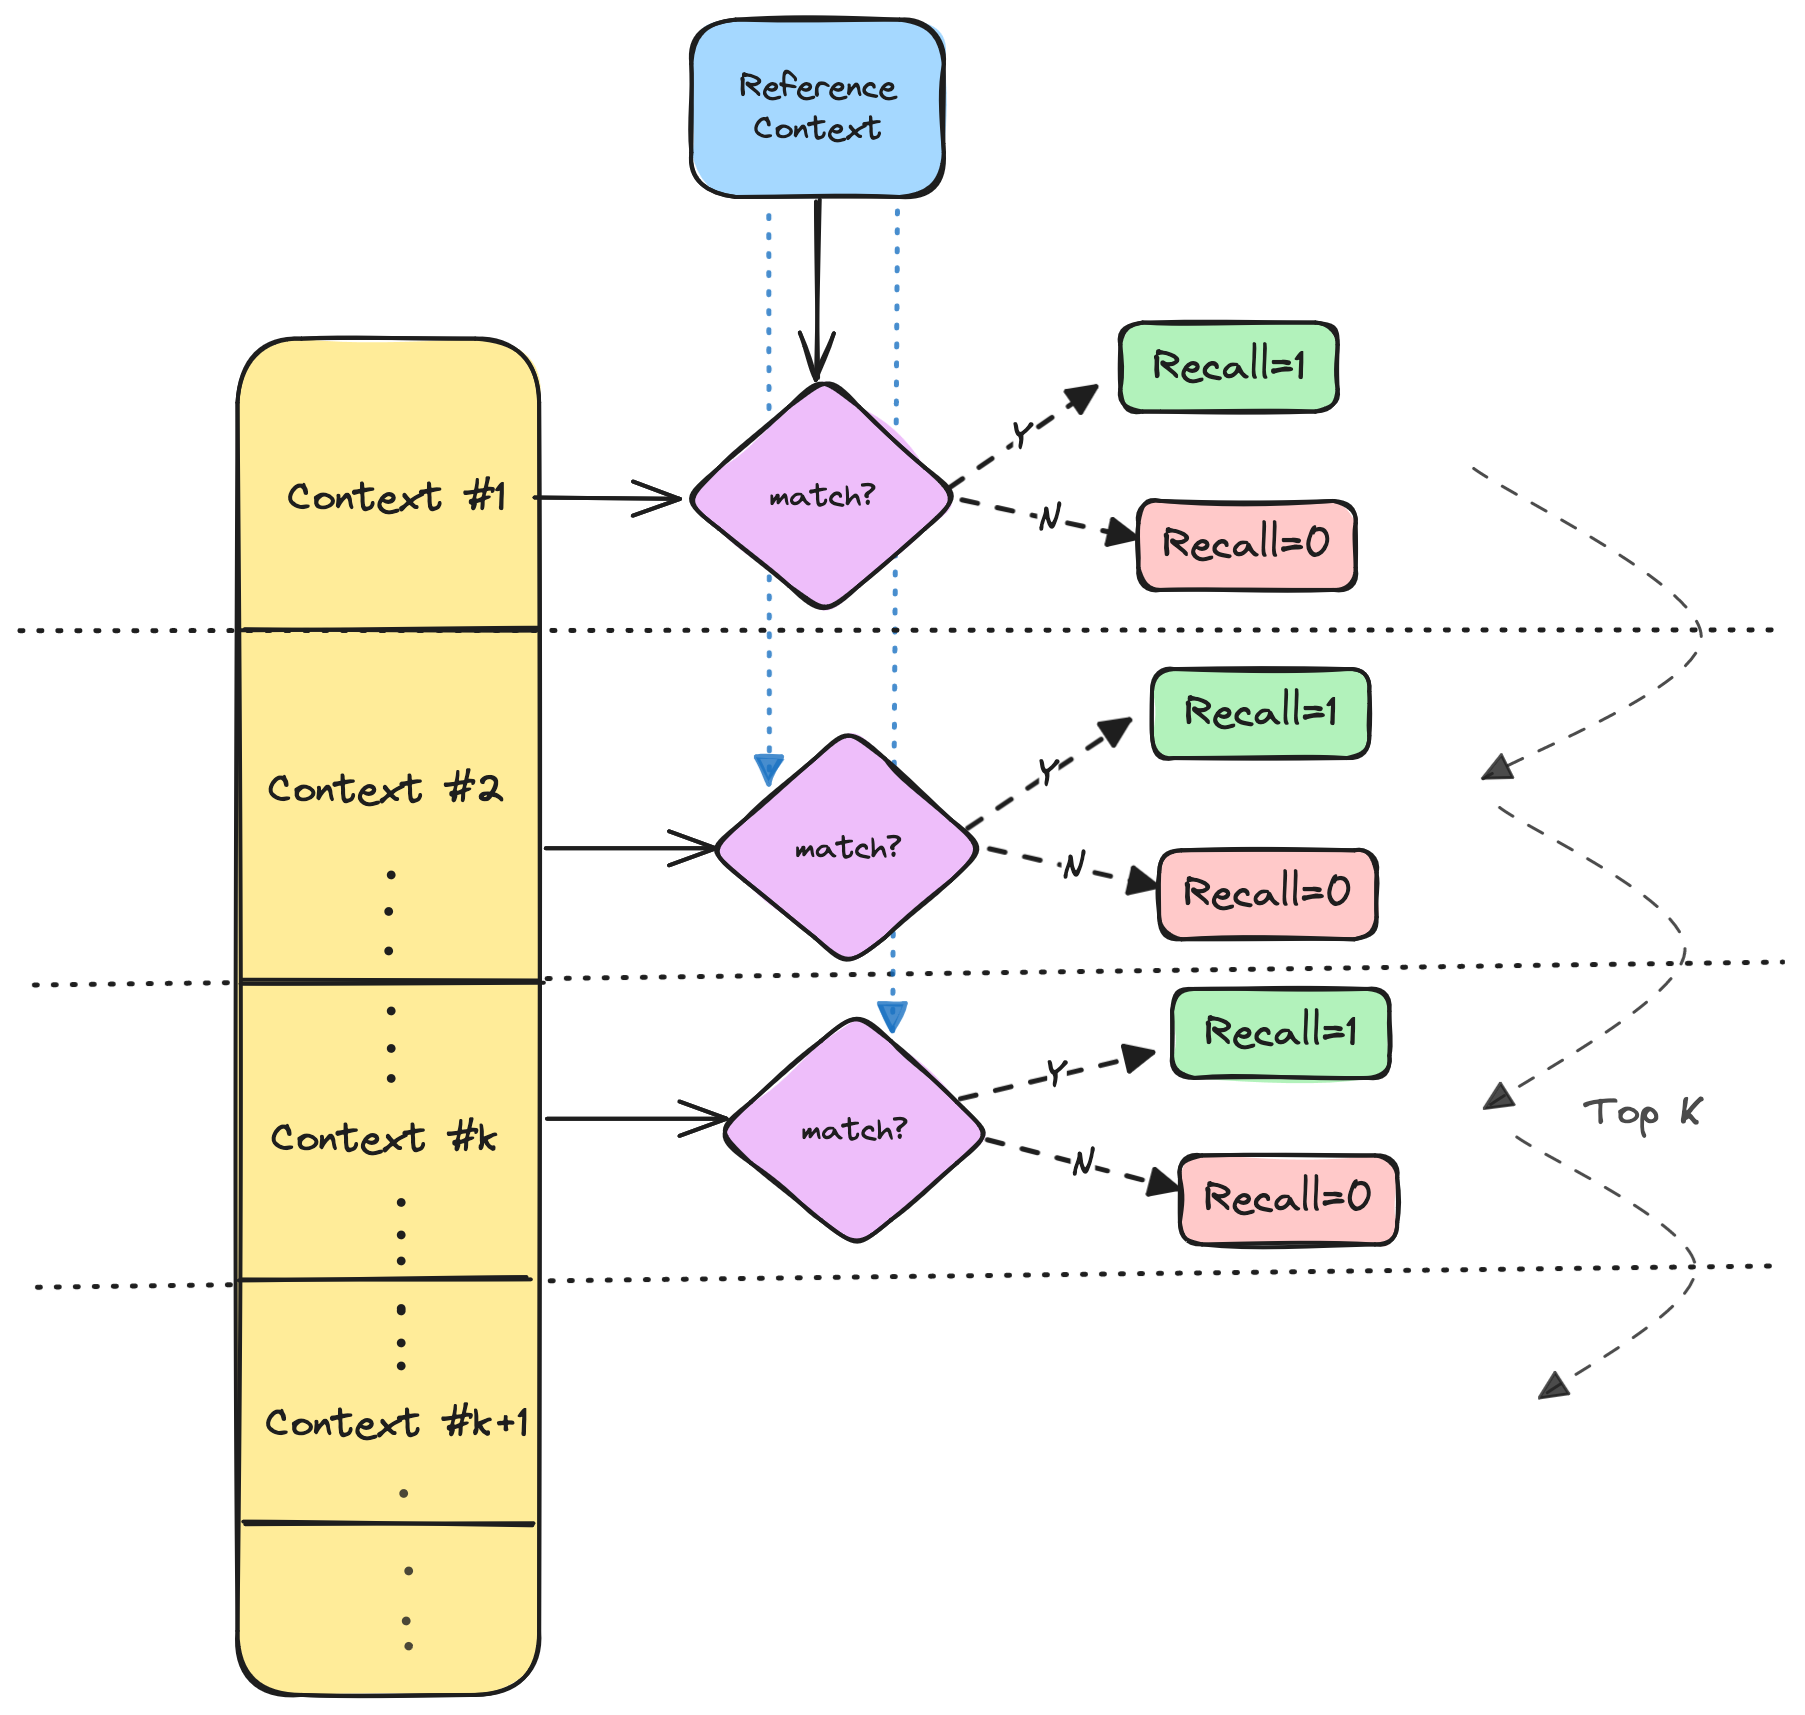

### Keyword-based evaluation

We compute the recall of retrieved contexts based on the overlapping of keywords between the
actual context (ground truth context) and the retrieved context.

In [101]:
def extract_keywords(text, top_k: int = 10):
    text = preprocess_text(text, top_k)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    keywords = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return set(keywords)

def preprocess_text(text, top_k=10):
    text = text.lower()
    r = Rake()
    r.extract_keywords_from_text(text)
    return " ".join(set(r.get_ranked_phrases()[:top_k]))

def compute_recall_kws(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    ref_keywords = extract_keywords(reference, top_k_kws)
    relevant_items = 0

    recall = 0.0

    if debug:
        print(f">>>>> reference = {reference}")
        print(f">>>>> reference keywords = {ref_keywords} | {len(ref_keywords)}")
    for idx, value in enumerate(retrieved_values, start=1):
        keywords = extract_keywords(value, top_k=top_k_kws)
        overlap = len(ref_keywords.intersection(keywords))
        score = overlap/len(ref_keywords)
        if debug:
            print(f">>>>> retrieved = {value}")
            print(f">>>>> retrieved kws = {keywords}")
            print(f">>>>> overlap = {overlap}")
            print(f">>>> score = {score}")

        if score >= threshold:
            recall = 1.0
        if idx >= top_k:
            break
    return recall

def evaluate_retrieval_keywords(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall = compute_recall_kws(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall
        ))
    return pd.DataFrame(results)

In [102]:
def batch_evaluate_retrieval_keywords(
    response: pd.DataFrame,
):
    final_df = []
    for threshold in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        for top_k in range(1, 10):
            for top_k_kws in [25, 50]:
                result = evaluate_retrieval_keywords(
                    response,
                    threshold=threshold,
                    top_k=top_k,
                    top_k_kws=top_k_kws,
                    debug=False
                )
                fname = f"data/evals/retrieval/keywords/eval-context-keywords-{threshold}-{top_k}-{top_k_kws}.csv"
                logger.debug(f"Dumping eval to {fname}")
                result.to_csv(fname, index=False)

def load_retrieval_eval_keywords(
    directory: str,
    pattern: Optional[str] = None
) -> pd.DataFrame:
    
    if pattern is None:
        pattern = "eval-context-keywords-([0-9.]+)-([0-9]+)-([0-9.]+).csv"
    
    dfs = []
    search_path = f"{directory}/eval-context-keywords*.csv"
    for path in glob.glob(search_path):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
            df["top_k_kws"] = int(match.group(3))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

def load_retrieval_eval(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

def peek_evaluation_result(df: pd.DataFrame, peek_type:str ="max"):
    df = df.copy()
    peek_type = peek_type.lower().strip()
    if peek_type in ["max", "good"]:
        df = df[df['recall'] == df['recall'].max()]
    else:
        df = df[df['recall'] == df['recall'].min()]
        
    row = df.sample(n=1).iloc[0]

    header_tag = "h4"
    display(HTML(f"<h3>{'Good' if peek_type in ['max', 'good'] else 'Bad'} Recall (Passage Overlap Threshold={row['threshold']}, top_k={row['top_k']})</h3"))
    display(HTML(f"<{header_tag}>Question</{header_tag}>"))
    print(row["question"])

    display(HTML(f"<{header_tag}>Generated Answer</{header_tag}>"))
    print(row["prediction"])

    display(HTML(f"<{header_tag}>Actual Answer</{header_tag}>"))
    print(row["answer"])

    display(HTML(f"<{header_tag}>Actual Context</{header_tag}>"))
    print(row["context"])

    display(HTML("<hr/>"))
    for idx, ctx in enumerate(row["retrieved_contexts"], start=1):
        display(HTML(f"<{header_tag}>Retrieved Context #{idx}</{header_tag}>"))
        print(ctx)

In [103]:
def plot_mean_recall_kws(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')
    df['top_k_kws'] = pd.to_numeric(df['top_k_kws'], errors='coerce')

    # df = df.groupby(['threshold', 'top_k', 'top_k_kws'])['recall'].mean().reset_index()

    # df_mean_recall = df.copy()

    # mean recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='hls')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

In [106]:
# eval_retrieval_kws = load_retrieval_eval_keywords(directory="../data/osdr-eval/evals/retrieval/keywords/")
eval_retrieval_kws = load_retrieval_eval("../data/osdr-eval/osdr-eval-retrieval-kws.csv")
print(eval_retrieval_kws.shape)
eval_retrieval_kws.head()

(30996, 9)


,context,question,answer,prediction,retrieved_contexts,recall,threshold,top_k,top_k_kws
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.25,6,25
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.25,6,25
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.25,6,25
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.25,6,25


In [107]:
eval_retrieval_kws.describe()

,recall,threshold,top_k,top_k_kws
count,30996.000000,30996.000000,30996.000000,30996.000000
mean,0.359595,0.375000,5.000000,37.500000
std,0.479889,0.085393,2.582031,12.500202
min,0.000000,0.250000,1.000000,25.000000
25%,0.000000,0.300000,3.000000,25.000000
50%,0.000000,0.375000,5.000000,37.500000
75%,1.000000,0.450000,7.000000,50.000000
max,1.000000,0.500000,9.000000,50.000000


In [117]:
# eval_retrieval_kws.to_csv("data/evals/osdr-eval-retrieval-kws.csv", index=False)

In [118]:
peek_evaluation_result(eval_retrieval_kws, peek_type="good")

Are Lunar Regolith benign substrates?


No, the lunar regolith is not considered a benign substrate for plant growth. The interaction between plants and lunar regolith can lead to stress in plants, slow development, and severe stress morphologies. Further research is needed to understand and mitigate these interactions for efficient plant growth in lunar habitats.


No, they are not benign substrates.


The extent to which plants can enhance human life support on other worlds depends on the ability of plants to thrive in extraterrestrial environments using in situ resources. Using samples from Apollo 11, 12 and 17, we show that the terrestrial plant Arabidopsis thaliana germinates and grows in diverse lunar regoliths. However, our results show that growth is challenging; the lunar regolith plants were slow to develop, expressed genes indicative of ionic stresses, and many showed severe stress morphologies. Therefore, although in situ lunar regolith can be useful for plant production in lunar habitats, they are not benign substrates. The interaction between plants and lunar regolith will need to be further elucidated, and likely mitigated, to enable efficient use of lunar regolith for life support.


the <b>lunar</b> <b>regolith</b> plants were slow to develop, expressed genes indicative of ionic stresses, and many showed severe stress morphologies. Therefore, although in situ <b>lunar</b> <b>regolith</b> can be useful for plant production in <b>lunar</b> habitats, they are not <b>benign</b> <b>substrates</b>. The interaction between plants and <b>lunar</b> <b>regolith</b> will need to be further elucidated, and likely mitigated, to enable efficient use of <b>lunar</b> <b>regolith</b> for life support.  Factor(s)  Factor  Ontology: Concept  Treatment  treatment  Organism(s)  Arabidopsis thaliana  Assay(s)  Measurement  Technology  Device Platform  transcription profiling  RNA Sequencing (RNA-Seq)  Illumina  Morphometric analysis  Image analysis  ImageJ  Project  Project Title


A11 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  2  LP.02 two leaves visible stage  Col-0, Leaves, Apollo 12 <b>regolith</b>, replicate 2  GSM5691017  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 12 <b>regolith</b>


A11 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  4  LP.04 four leaves visible stage  Col-0, Leaves, Apollo 12 <b>regolith</b>, replicate 1  GSM5691013  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 12 <b>regolith</b>


treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  6  LP.06 six leaves visible stage  Col-0, Leaves, Apollo 17 <b>regolith</b>, replicate 4  GSM5691026  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 17 <b>regolith</b>  growth protocol  Earth surface  A17 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well.


A11 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  0  only cotyledonary node visible  Col-0, Leaves, Apollo 12 <b>regolith</b>, replicate 3  GSM5691021  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 12 <b>regolith</b>  growth protocol


treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  4  LP.04 four leaves visible stage  Col-0, Leaves, Apollo 17 <b>regolith</b>, replicate 3  GSM5691022  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 17 <b>regolith</b>  growth protocol  Earth surface  A17 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well.


treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  20 day  10  LP.10 ten leaves visible stage  Col-0, Leaves, Apollo 11 <b>regolith</b>, replicate 4  GSM5691024  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 11 <b>regolith</b>  growth protocol  Earth surface  A11 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well.


A17 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  6  LP.06 six leaves visible stage  Col-0, Leaves, JSC-1A, replicate 3  GSM5691019  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  JSC-1A <b>lunar</b> simulant


A17 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  2  LP.02 two leaves visible stage  Col-0, Leaves, JSC-1A, replicate 2  GSM5691015  Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  JSC-1A <b>lunar</b> simulant


Arabidopsis thaliana  Wild Type  Col-0  aboveground biomass  Arabidopsis Biological Resource Center TAIR CS70000  Apollo 12 <b>regolith</b>  growth protocol  Earth surface  A12 <b>Lunar</b> <b>regolith</b> and Rockwool plug moistened with a nutrient solution of 0.125x strength Murashige and Skoog nutrient solution, pH 5.7  900 milligram  Light Emitting Diode Device  vented terrarium chamber  22 degree Celsius  16:8 light:dark hour  21 day  2-4 seeds per well. The seedlings thinned to 1 on day 6 or 8  treatment protocol  plant embryo dormant stage  sample collection  Liquid Nitrogen  -80 degree Celsius  21 day  6  LP.06 six leaves visible stage


In [119]:
peek_evaluation_result(eval_retrieval_kws, peek_type="bad")

What kind of tissues did this study use?


The study mentioned in the context used various tissues such as lumbar spine, tibialis anterior, tibia, soleus, femur, and extensor digitorum longus from mice for different assays like DXA Scanning and Western blot.


Hair


In each mission, five strands of hair were sampled six times from each astronaut within the period of July 2009 to February 2013. The sampling timings were as follows: 6 sampling time points (Fig 1); first preflight (Launch (L) -180 to -90 days: 6 to 3 months before launch), second preflight (L-60 to -14: 2 months to 2 weeks before launch), first inflight (L+20 to 37: 20 to 37 days after launch), second inflight (Return (R) -20 to -7: 20 to 7 days before return), first postflight (R+2 to 7: 2 to 7 days after return), and second postflight (R+30 to 90: from 1 to 3 months after return). In sampling day, two astronauts were paired and plucked another hair sample using tweezer in the direction of hair growth without damaging the hair roots. These plucked samples were stored at -80C until analysis.


In response to these and other observations, the Rapid Freeze hardware was built for <b>use</b> on the International Space Station. The Rapid Freeze hardware freezes mouse <b>tissues</b> (Glovebox freezer) and whole carcasses (Cryochiller) at rates closely mimicking those attained with immersion in liquid nitrogen. Because this hardware will be <b>used</b> extensively on future rodent research missions, it is crucial to understand whether or not it preserves signals in gene expression data in order to maximize the value of these rare and expensive spaceflight experiments. Therefore, this <b>study</b> was designed with three goals:


This <b>study</b> derives results from the DXA Scanning assay <b>using</b> lumbar spine <b>tissue</b> from HLS mice. The lumbar spine data in this <b>study</b> are related to other <b>studies</b> <b>using</b> <b>tissues</b> from the same experiment; OSD-654 (tibia), OSD-660 (tibialis anterior), OSD-662 (soleus), OSD-663 (femur), and OSD-664 (extensor digitorum longus).  Factor(s)  Factor  Ontology: Concept  Hindlimb Unloading  Hindlimb Suspension  Genotype  Genotype  Organism(s)  Mus musculus  Assay(s)  Measurement  Technology  Device Platform  Bone Microstructure  Dual-Energy X-Ray Absorptiometry  osteosys insight  Project  Payload Identifier  GROUND-2  Project Type  Ground <b>Study</b>  Experiment Platform  Hindlimb Unloading  Sponsoring Agency  NASA, CSA


01-Jul-2011  notifications share  GeneLab ID : GLDS-92 DOI : 10.26030/2k69-6j41 Source Accession : E-GEOD-16935  Cite this <b>Study</b>  info Description  Description  Accumulating data suggest that the biological responses to high and low doses of radiation are qualitatively different, necessitating the direct <b>study</b> of low dose responses. Most such <b>studies</b> have utilized 2-dimensional culture systems, which may not fully represent responses in 3-dimensional <b>tissues</b>.


This <b>study</b> derives results from the Western blot assay <b>using</b> tibialis anterior <b>tissue</b> from the RR9 mission. The tibialis anterior data in this <b>study</b> are related to other <b>studies</b> <b>using</b> <b>tissues</b> from the same experiment; OSD-654 (tibia), OSD-661 (lumbar spine), OSD-662 (soleus), OSD-663 (femur), and OSD-664 (extensor digitorum longus).  Factor(s)  Factor  Ontology: Concept  Spaceflight  Space Flight  Organism(s)  Mus musculus  Assay(s)  Measurement  Technology  Device Platform  protein quantification  Western Blot  BioRad ChemiDoc  Project  Payload Identifier  RR-9  Project Type  Spaceflight <b>Study</b>  Flight Program  ISS  Experiment Platform  Rodent Habitat  Sponsoring Agency  NASA  NASA Center


strength, and promoted the oxidative fiber type with Earth-based hindlimb unloading. In bone, GSK3 activation was enhanced after spaceflight; and strikingly, muscle-specific Gsk3 deletion increased bone mineral density in response to hindlimb unloading. Thus, future <b>studies</b> should test the effects of GSK3 inhibition during spaceflight. This <b>study</b> derives results from the Western blot assay <b>using</b> tibialis anterior <b>tissue</b> from the RR9 mission. The tibialis anterior data in this <b>study</b> are related to other <b>studies</b> <b>using</b> <b>tissues</b> from the same experiment;


different molecular mechanisms of tumorigenesis. Also seen in this <b>study</b> was novel unmapped transcripts that were significantly affected by HZE. To investigate the biological functions of these transcripts, we <b>used</b> a machine learning technique known as self-organizing maps (SOMs) to characterize the transcriptome expression profiles of 60 samples (45 HZE-irradiated, 15 non-irradiated control) from liver <b>tissues</b>. A handful of localized modules in the maps emerged as groups of co-regulated and co-expressed transcripts. The functional context of these modules was discovered <b>using</b> overrepresentation analysis.


order to maximize the value of these rare and expensive spaceflight experiments. Therefore, this <b>study</b> was designed with three goals: 1) To evaluate the temperature profile of the Cryochiller and Glovebox freezer cartridges (Rapid Freeze hardware) over time during mock on-orbit procedures; 2) To determine the freezing profiles of <b>tissues</b> and carcasses <b>using</b> Rapid Freeze hardware at both optimal and sub-optimal temperatures (to mimic on-orbit operations), compared with those frozen in liquid nitrogen (the laboratory gold standard) or frozen at -80 C (the current standard method); 3) To identify gene expression changes in a) <b>tissues</b> that were


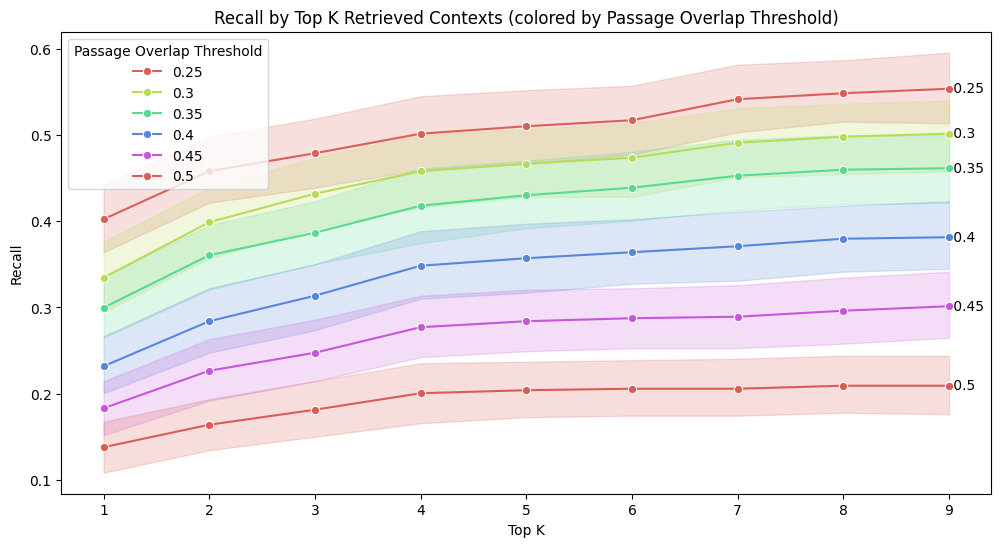

In [108]:
plot_mean_recall_kws(eval_retrieval_kws)

### Semantic Retrieval Evaluation

In [109]:
BERT_SCORE = BertScore(per_instance_score=True)

In [110]:
def compute_recall_semantic(
    reference: str,
    retrieved_values: List[str],
    top_k: int = 1,
    top_k_kws: int = 10,
    threshold:float = 0.5,
    debug: bool = False,
) -> float:
    
    recall = 0.0

    retrieved_values = retrieved_values[:top_k]
    references = [reference] * len(retrieved_values)
    predictions = retrieved_values.copy()
    result = BERT_SCORE(references=references, predictions=predictions)
    max_score = max(result.extra["bertscore"]["recall"])
    return float(max_score >= threshold), max_score

def evaluate_retrieval_semantic(
    response: pd.DataFrame,
    threshold=0.5,
    top_k:int = 1,
    top_k_kws: int = 10,
    debug:bool=False
) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)

    response = response[response.retrieved_contexts.str.len() != 0]

    results = []
    for row in response.itertuples():
        context = row.context
        retrieved_contexts = row.retrieved_contexts
        retrieved_contexts = list(map(lambda x: x["page_content"], retrieved_contexts))
        recall, score = compute_recall_semantic(
            context,
            retrieved_contexts,
            threshold=threshold,
            top_k=top_k,
            top_k_kws=top_k_kws,
            debug=debug
        )
        if debug:
            print(recall, score)
        results.append(dict(
            context=context,
            question=row.question,
            answer=row.reference,
            prediction=row.prediction,
            retrieved_contexts=retrieved_contexts,
            recall=recall,
            score=score,
        ))
    return pd.DataFrame(results)

In [111]:
def batch_eval_semantic(response):
    thresholds = [0.5, 0.65]
    top_k_vals = [1, 5, 10]
    for threshold in thresholds:
        for top_k in top_k_vals:
            logger.debug(f"Evaluating for threshold={threshold}, top_k={top_k}")
            result = evaluate_retrieval_semantic_v2(
                response,
                threshold=threshold,
                top_k=top_k, 
                top_k_kws=50,
                debug=False)
            fname = f"data/evals/retrieval/bertscore/eval-context-bertscore-{threshold}-{top_k}.csv"
            logger.debug(f"Dumping eval to {fname}")
            result.to_csv(fname, index=False)

def load_retrieval_eval_semantic(
    directory: str,
    pattern: Optional[str] = None
) -> pd.DataFrame:
    
    if pattern is None:
        pattern = "eval-context-bertscore-([0-9.]+)-([0-9]+).csv"
    
    dfs = []
    search_path = f"{directory}/eval-context-bertscore*.csv"
    for path in glob.glob(search_path):
        df = pd.read_csv(path)
        match = re.search(pattern, path)
        if match:
            df["threshold"] = float(match.group(1))
            df["top_k"] = int(match.group(2))
        dfs.append(df)
    df = pd.concat(dfs, axis=0)
    df["retrieved_contexts"] = df["retrieved_contexts"].apply(ast.literal_eval)
    return df

In [112]:
def plot_mean_recall_semantic(df, figsize=(12, 6)):
    df = df.copy()
    df['top_k'] = pd.to_numeric(df['top_k'], errors='coerce')
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    df['recall'] = pd.to_numeric(df['recall'], errors='coerce')

    # recall vs. top_k with lines for each threshold
    plt.figure(figsize=figsize)
    ax = sns.lineplot(data=df, x='top_k', y='recall', hue='threshold', marker='o', palette='dark')
    plt.title('Recall by Top K Retrieved Contexts (colored by Passage Overlap Threshold)')
    plt.xlabel('Top K')
    plt.ylabel('Recall')
    plt.legend(title='Passage Overlap Threshold')

    lines, labels = ax.get_legend_handles_labels()
    for line, label in zip(ax.lines, labels[:]):  # Skip the first label as it is the legend title
        x, y = line.get_data()
        plt.text(x[-1], y[-1], f' {label}', verticalalignment='center')  # Annotate the end of the line
    
    plt.show()

    # recall vs. threshold with lines for each top_k_kws
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')
    plt.title('Recall by Passage Overlap Threshold')
    plt.xlabel('Passage Overlap Threshold')
    plt.ylabel('Recall')
    plt.show()

In [113]:
# eval_retrieval_semantic = load_retrieval_eval_semantic("../data/osdr-eval/evals/retrieval/bertscore/")
eval_retrieval_semantic = load_retrieval_eval("../data/osdr-eval/osdr-eval-retrieval-semantic.csv")
eval_retrieval_semantic.head()

,context,question,answer,prediction,retrieved_contexts,recall,score,threshold,top_k
0,Genome-wide transcriptional profiling showed t...,Where were the gene expression alterations in ...,reducing gravity levels in the International S...,The gene expression alterations in Drosophila ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.709230,0.5,10
1,Genome-wide transcriptional profiling showed t...,What kind of experiments showed differential r...,simulation experiments on ground testing space...,Experiments involving reducing gravity levels ...,[26-Jun-2013 notifications share GeneLab ID ...,1.0,0.701952,0.5,10
2,Genome-wide transcriptional profiling showed t...,What is overrepresented in the different exper...,the same GO groups including a large multigene...,"The same GO groups, including a large multigen...","[Curiously, although <b>particular</b> <b>gene...",1.0,0.706340,0.5,10
3,Genome-wide transcriptional profiling showed t...,What are the implications of the findings in t...,The findings indicate that the finely adjusted...,The findings suggest that the transcriptome is...,"[These results suggest that, in addition to be...",1.0,0.722527,0.5,10
4,The objective of the Rodent Research-5 (RR-5) ...,What was the main goal of the Rodent Research-...,to evaluate bone loss in mice during spaceflig...,The main goal of the Rodent Research-5 (RR-5) ...,[12-Aug-2019 notifications share GeneLab ID ...,1.0,0.587473,0.5,10


In [114]:
eval_retrieval_semantic.describe()

,recall,score,threshold,top_k
count,3444.000000,3444.000000,3444.000000,3444.000000
mean,0.527294,0.581817,0.575000,5.333333
std,0.499327,0.107731,0.075011,3.682322
min,0.000000,0.357976,0.500000,1.000000
25%,0.000000,0.490861,0.500000,1.000000
50%,1.000000,0.572280,0.575000,5.000000
75%,1.000000,0.675793,0.650000,10.000000
max,1.000000,0.936264,0.650000,10.000000


In [61]:
# eval_retrieval_semantic.to_csv("../data/osdr-eval/evals/osdr-eval-retrieval-semantic.csv", index=False)

In [110]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="good")

Why was in vivo pQCT used?


In vivo pQCT was used to measure trabecular bone density at the proximal tibia and assess the structural and functional skeletal alterations in rats exposed to varying degrees of partial weight bearing over different time periods.


To find trabecular bone density


Reduced skeletal loading leads to marked bone loss. Animal models of hindlimb suspension are widely used to assess alterations in skeleton during the course of complete unloading. More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle. Here, we extended these studies to determine the structural and functional skeletal alterations in 14-week-old male Wister rats exposed to 20%, 40%, 70%, or 100% of body weight for 1, 2, or 4 weeks (n  equals 11–12/group). Using in vivo pQCT, we found that trabecular bone density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without evidence of a plateau by 4 weeks. Ex vivo measurements of trabecular microarchitecture in the distal femur by microcomputed tomography revealed deficits in bone volume fraction, 2 and 4 weeks after u

<b>Using</b> <b>in</b> <b>vivo</b> <b>pQCT</b>, we found that trabecular bone density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without evidence of a plateau by 4 weeks. Ex vivo measurements of trabecular microarchitecture in the distal femur by microcomputed tomography revealed deficits in bone volume fraction, 2 and 4 weeks after unloading. Histologic analyses of trabecular bone in the distal femur revealed the decreased osteoblast number and mineralizing surface in unloaded rats. Three-point bending of the femoral diaphysis indicated modest or no reductions in femoral stiffness and estimated modulus due to PWB.


More recently, the effects of partial unloading on the musculoskeletal system have been interrogated in mice and rats, revealing dose-dependent effects of partial weight bearing (PWB) on the skeleton and skeletal muscle. Here, we extended these studies to determine the structural and functional skeletal alterations in 14-week-old male Wister rats exposed to 20%, 40%, 70%, or 100% of body weight for 1, 2, or 4 weeks (n equals 11-12/group). <b>Using</b> <b>in</b> <b>vivo</b> <b>pQCT</b>, we found that trabecular bone density at the proximal tibia declined in proportion to the degree of unloading and continued progressively with time, without


5.0, 5.5, 6.0 millimeter  Proximal Tibia Plateau  20.0, 20.5 millimeter  100 micrometer  Not Available  LSDS-41_peripheral_quantitative_computed_tomography_pQCT_LSDS-41_<b>pQCT_KoSUBMITTED.xlsx</b>  ALSDA Transformed Data  LSDS-41_peripheral_quantitative_computed_tomography_pQCT_LSDS-41_<b>pQCT_KoTRANSFORMED.csv</b>  Items per page:  25  1 - 25 of 120  menu_book Publications  Dose-dependent skeletal deficits due to varied reductions in mechanical loading in rats  Authors : Ko FC, Mortreux M, Riveros D, Nagy JA, Rutkove SB, Bouxsein ML.  DOI : 10.1038/s41526-020-0105-0  sim_card_download Files  Study Files Selected: 0  Search Files  search  OSD-608  Study Metadata Files  <b>peripheral_quantitative_computedtomography_pQCT</b>  view_timeline Version History  Selected Version  Version 1  Updated Date: 17-May-2023  Changes: New data release


The data were analyzed using BRB-Array Tools (NIH), and further gene ontology analysis and network analysis was performed with Panther (Applied Biosystems) and IPA (Ingenuity), accordingly. Significantly responding genes were identified at all distances and included sets common to both direct and bystander responses. False discovery rate in bystander samples did not exceed 20% (p=0.001) and was sufficiently low in the samples obtained after the whole tissue exposure (0.06-1.16%). Analysis of the fragments cut at the same distance revealed 52, 54 and 88 differentially expressed genes.


Gamma irradiations were completed at 8:40 am, while HZE irradiations were conducted in two runs (due to space limitations) which were completed at 1:09 and 1:28pm respectively. Gamma treated seedlings were sampled at 10:10 am, 11:40 am, 2:55 pm, 8:40 pm, and 8:40 am. HZE treated seedlings were sampled at 2:39 pm, 4:09 pm, 7:24 pm, 1:09 am, and 1:09 pm. Un-irradiated WT and atm-1 control seedlings were sampled at 10:45 am on Day #1 and 9:15 am on Day #2.


PCR) methods after propidium monoazide (PMA) treatment. The 16S-tag and metagenome analyses were used to elucidate viable microbial diversity. The cultivable bacterial population yield from the polyester wipes was very high (5 to 7-logs) when compared with the contact slides (10^2 to 10^3 CFU/m2). The PMA-qPCR analysis showed considerable variation of viable bacterial population (10^5 to 10^9 16S rDNA gene copies/m2) among locations sampled.


We performed comparative RNA-Seq transcriptomic analysis to assess the carcinogenic effects of 600 MeV/n 56Fe (0.2 Gy), 1 GeV/n 16O (0.2 Gy), and 350 MeV/n 28Si (0.2 Gy) ions in a mouse model for radiation-induced hepatocellular carcinoma. C3H/HeNCrl mice were subjected to total body irradiation to simulate space HZE-irradiation environment and liver tissues were extracted at five different time points post-irradiation to investigate the time-dependent gradual carcinogenic response at the transcriptomic level.


In order to identify changes in gene expression that may be informative for detecting such exposure, and to begin examining the molecular responses involved, we have profiled global gene expression in mice injected with 137CsCl. We extracted RNA from the blood of control or 137CsCl-injected mice at 2, 3, 5, 20 or 30 days after exposure. Gene expression was measured using Agilent Whole Mouse Genome Microarrays, and the data was analyzed using BRB-ArrayTools.


In [111]:
peek_evaluation_result(eval_retrieval_semantic, peek_type="bad")

What does WS stand for?


In the context provided, WS likely stands for a specific genotype or ecotype of Arabidopsis thaliana, a type of plant used in the study.


Wassilewskija.


The increasing availability of flights on suborbital rockets creates new avenues for the study of spaceflight effects on biological systems, in particular the transitions between hypergravity and microgravity. This paper presents an initial comparison of the responses of Arabidopsis thaliana to suborbital and atmospheric parabolic flights as an important step toward characterizing these emerging suborbital platforms and their effects on biology. Transcriptomic profiling of the response of the Arabidopsis ecotype Wassilewskija (WS) to the aggregate spaceflight experiences in the Blue Origin New Shepard and Virgin Galactic SpaceShipTwo rockets revealed that the transcriptomic load induced by flight differed greatly between the two flights, yet was biologically related to traditional parabolic flight responses. The sku5 skewing mutant and 14-3-3κ:GFP regulatory protein overexpression lines each showed altered intra-platform responses compared to WS in the Blue Origin and parabolic flights

The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep4  F4H2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep5  F6H2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day


These differential genotypic responses suggest that genetic manipulation could further reduce, or perhaps eliminate the metabolic cost of spaceflight adaptation. When plants were germinated and then left in the dark on the ISS, the <b>WS</b> genotype actually mounted a larger transcriptome response than Col-0, suggesting that the in-space light environment affects physiological adaptation, which implies that manipulating the local habitat can also substantially impact the metabolic cost of spaceflight adaptation.  Factor(s)  Factor  Ontology: Concept  Ecotype  Ecotype  Spaceflight  Space Flight  Treatment  treatment  Organism(s)  Arabidopsis thaliana  Assay(s)  Measurement  Technology  Device Platform  transcription profiling  RNA Sequencing (RNA-Seq)


<b>Atha_WS</b>-0_Col-0_Shoot_GC_Rep5  G6S2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced solid media plates; Advanced Biological Research System (ABRS); GC Unit, OES chamber at KSC  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Ground Control  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep1  F2H1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep2  F4H1


The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep4  F4S2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep5  F6S2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day


ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep2  F4H1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Hypocotyl_FLT_Rep3  F6H1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  hypocotyl  RNALater  Plants


Plants  <b>Atha_WS</b>-0_Whole-Plant_GC_Rep3  GCTAGES6  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced solid media plates; Advanced Biological Research System (ABRS); GC Unit, OES chamber at KSC  <b>WS</b>  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Ground Control  whole plant  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep1  F2S1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep2  F4S1  P-MTAB-28101


Advanced Biological Research System (ABRS); The EXPRESS Rack  <b>WS</b>  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  whole plant  RNALater  Plants  <b>Atha_WS</b>-0_Whole-Plant_FLT_Rep3  FLTAGES6  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  <b>WS</b>  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  whole plant  RNALater  Plants  <b>Atha_WS</b>-0_Whole-Plant_GC_Rep1  GCTAGES2  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced solid media plates; Advanced Biological Research System (ABRS); GC Unit, OES chamber at KSC  <b>WS</b>  ABRS  22 -24 degree Celsius  12 day


solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_GC_Rep1  G2S1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced solid media plates; Advanced Biological Research System (ABRS); GC Unit, OES chamber at KSC  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Ground Control  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_GC_Rep2  G4S1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates;


22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep2  F4S1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants  <b>Atha_WS</b>-0_Col-0_Shoot_FLT_Rep3  F6S1  P-MTAB-28101  Arabidopsis thaliana  solid 0.5x MS media plates; Advanced Biological Research System (ABRS); The EXPRESS Rack  60% <b>WS</b>, 40% Col-0  ABRS  22 -24 degree Celsius  12 day  below -40 degree Celsius  Space Flight  shoot  RNALater  Plants


The whole-genome sequences (WGS) of three pathogenic bacterial strains collected from the International Space Station (ISS) were generated and identified as being part of Class Alphaproteobacteria. The WGS studies would enable further genomic/biochemical characterization of taxa for these bacteria that have been subjected to the microgravity conditions of space.  Factor(s)  Factor  Ontology: Concept  Spaceflight  Space Flight  Strain  strain  Organism(s)  Agrobacterium genomosp. 3  Assay(s)  Measurement  Technology  Device Platform  genome sequencing  nucleotide sequencing  Illumina NovaSeq 6000  Project  Payload Identifier  ISS-MO (MT-1B)  Project Title  ISS Microbial Observatory (Microbial Tracking-1B)  Project Type  Spaceflight Study  Flight Program


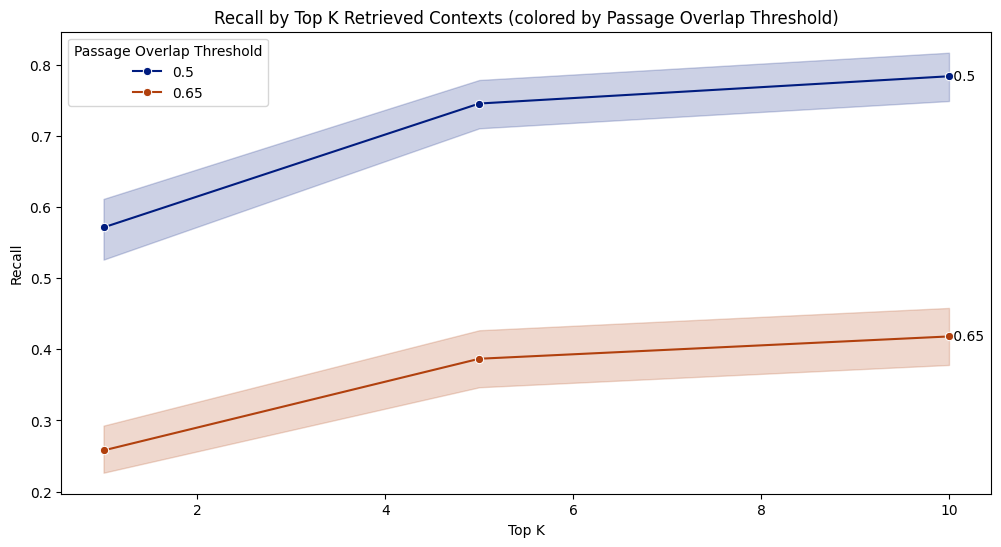

/var/folders/_y/xn9wmmrx1_s68jvjw4gzmxfm0000gn/T/ipykernel_64803/4215088815.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='threshold', y='recall', marker='o', palette='vlag')


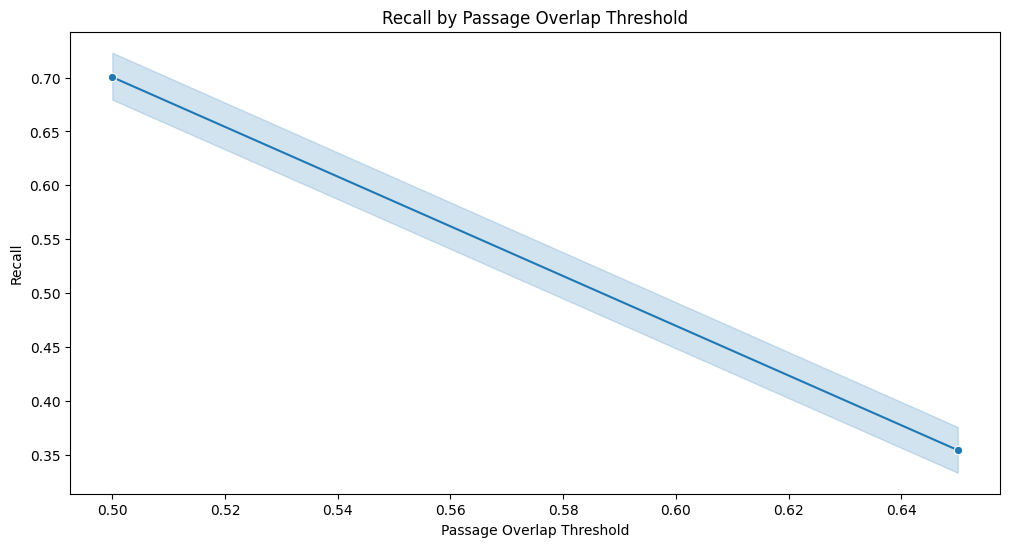

In [115]:
plot_mean_recall_semantic(eval_retrieval_semantic)

## QA Evaluation

Here we focus on semantic evaluation of generated answers which suggest the correctness of the answer w.r.t reference answer.

We use following metrics:


1. **Exact Match**
2. **METEOR** (Metric for Evaluation of Translation with Explicit Ordering)
    - more aligned with human judgment
    - accounts for exact word matches, *synonyms*, and *paraphrases*
    - useful for evaluating correctness across varied wordings
3. **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation)
   - focuses on recall, measuring *word overlaps* with reference
   - indicates content overlap rather than linguistic quality
   - lower score may suggest fewer exact word matches
4. **BERT Score**
    - *semantic* similarity using contextual embeddings
    - measures how well the generated answers match with references in meaning
    - generalized comparison for a variety of downstream tasks (QA, Translation, Summarization, etc.)

In [116]:
def evaluate_qa(response: pd.DataFrame) -> pd.DataFrame:
    if "question" not in response and "prediction" not in response and "reference" not in response:
        response = simplify_response(response)
    evaluator = Evaluator(metrics=[
        BertScore(),
        ExactMatchMetric(),
        MeteorMetric(),
        RougeMetric(),
    ])
    results = evaluator(
        references=response["reference"].to_list(),
        predictions=response["prediction"].to_list()
    )
    results = pd.DataFrame(results)
    return results

In [117]:
def simplify_response(response: pd.DataFrame) -> pd.DataFrame:
    response = response.copy()
    response["result"] = response["result"].apply(ast.literal_eval)
    res = []
    for row in response.itertuples():
        res.append(dict(
            context=row.reference_context,
            context_hash=row.context_hash,
            question=row.question,
            reference=row.reference_answer,
            ground_truth=row.reference_answer,
            prediction=row.result["answer"],
            retrieved_contexts=row.result["source_documents"]
        ))
    return pd.DataFrame(res)

In [118]:
def plot_eval_result(df: pd.DataFrame):
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='metric_name', y='score', data=df, palette='husl')
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.3f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.title('Comparison of Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.show()

In [ ]:
eval_qa = evaluate_qa(
    response=pd.read_csv("../data/osdr-eval/responses-simplified-gpt-3.5-turbo-rephrased.csv")
)

/Users/npantha/dev/impact/projects/smd-llm-workshop/venv/lib/python3.10/site-packages/jury/metrics/_core/auto.py:106: UserWarning: Metric exact_match is not available on jury, falling back to evaluate metric. You may not fully utilize this metric for different input types, e.g multiple predictions or multiple references.
  warnings.warn(


In [ ]:
eval_qa

In [ ]:
plot_eval_result(eval_qa)

# Footnotes
- [evalem](https://github.com/NASA-IMPACT/evalem)